<a href="https://colab.research.google.com/github/Segtanof/pyfin/blob/main/07_Case_Study_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study

The idea is that you will work on a case study to deepen (and expand!) your knowledge of Python, WRDS databases and all other concepts we have learned in the course up to this point.

Unless the task explicitly says "manually" do something, you should solve all questions with code.

The case study is similar to the take-home exam.

## Imports

Please collect all imports in the cells below and do not import more packages further down in the notebook.

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Introductory exercises

In the following, you have a list of tickers.

- Manually comment out the ticker with length 3.
- How many tickers are in the list?
- Collect the second-to-last character of all tickers in a list.
- Collect all tickers in a list that contain the letter "i" (case insensitive).
- How many letters "S" are in all of the tickers together?
- Make a list that has tuples as elements. The first element in each tuple should be the ticker. The second element in each tuple should be the index position of the ticker in the list, squared.

In [ ]:
list_of_tickers = [
    'ISDS',
    'ISDX',
    'FLSA',
    'GTiP',
    'BSDE',
    'XKCP',
    # 'SWI',
]


In [ ]:
len(list_of_tickers)

6

In [ ]:
[ticker[-2] for ticker in list_of_tickers]

['D', 'D', 'S', 'i', 'D', 'C']

In [ ]:
[ticker for ticker in list_of_tickers if "i" in ticker.lower()]

['ISDS', 'ISDX', 'GTiP']

In [ ]:
# As a list comprehension
sum([1 for ticker in list_of_tickers for c in ticker if c=="S"])


# As a written out for loop
counter = 0
for ticker in list_of_tickers:
  for character in ticker:
    if character == "S":
      counter = counter + 1

counter

5

In [ ]:
[(ticker, i**2) for i, ticker in enumerate(list_of_tickers)]

[('ISDS', 0),
 ('ISDX', 1),
 ('FLSA', 4),
 ('GTiP', 9),
 ('BSDE', 16),
 ('XKCP', 25)]

## Downloading and preparing data

Download CRSP data from WRDS. Download daily stock price data for the period from 2019-01-01 to 2019-12-31 for all companies.

Select the following columns:
- permco
- ticker
- siccd
- prc
- ret
- shrout
- vwretd

Note that permno (a share class identifier) will be downloaded automatically.

- Upload it to your Google Drive.
- Load it into Colab.
- Clean the column names by converting them to lowercase.

**IF YOU DO NOT (YET) HAVE ACCESS TO WRDS**

Uncomment the lines below to load provided data.

- [Variable descriptions](https://drive.google.com/file/d/1TRNV8KZBMk6bwHFJgDxtFdUHMPHLYerE/view?usp=sharing)
- [shrout details](https://drive.google.com/file/d/1puGQXoAnRdu3rfpYg3KPWZXuLGUokARB/view?usp=sharing)

In [ ]:
crsp_file = "/content/drive/MyDrive/Colab Notebooks/Python course 2024-11/data/crsp_casestudy.csv.gz"

# If you do not have access to WRDS yet, uncomment the following lines
!gdown 163Xu08XdGnFeMxCf7yOeirm3Uj_Mx2W5
crsp_file = "/content/crsp_casestudy.csv.gz"

Downloading...
From: https://drive.google.com/uc?id=163Xu08XdGnFeMxCf7yOeirm3Uj_Mx2W5
To: /content/crsp_casestudy.csv.gz
100% 26.2M/26.2M [00:00<00:00, 81.0MB/s]


In [ ]:
crsp_unclean = pd.read_csv(crsp_file, low_memory=False, parse_dates=['date'])

# Let's rename the columns to lowercase to save us the shift key
crsp_unclean.columns = crsp_unclean.columns.str.lower()

Ensure we have numeric datatypes for the relevant variables.

In [ ]:
crsp = crsp_unclean.assign(ret = lambda x: pd.to_numeric(x['ret'], errors='coerce'))

In [ ]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912001 entries, 0 to 1912000
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   permno  int64         
 1   date    datetime64[ns]
 2   siccd   object        
 3   ticker  object        
 4   permco  int64         
 5   prc     float64       
 6   ret     float64       
 7   shrout  float64       
 8   vwretd  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 131.3+ MB


Show the first 3 rows

In [ ]:
crsp.head(3)

,permno,date,siccd,ticker,permco,prc,ret,shrout,vwretd
0,10026,2019-01-02,2052,JJSF,7976,141.00,-0.024829,18774.0,0.001796
1,10026,2019-01-03,2052,JJSF,7976,143.02,0.014326,18774.0,-0.021043
2,10026,2019-01-04,2052,JJSF,7976,144.84,0.012725,18774.0,0.033410


## Adding market capitalization and industry

### Industry

Add the 2-digit SIC code industry as a column to your data.

A 2-digit SIC code industry means that the first 2 numbers in the SIC code are considered to be the same industry.

Note that these should be strings!

In [ ]:
crsp = crsp.assign(industry = lambda x: x['siccd'].str.slice(0,2))
# slice is essentially equal to [:2] on a regular string (remember we called this 'slicing')

### Market capitalization

Calculate the market capitalization `mcap` from `prc` and `shrout` and add it to the DataFrame as a new column.

Check the variable description of `shrout` to avoid mistakes.

In [ ]:
# Shares outstanding are in USD thousands. So to get the accurate dollar values, multiply it with 1000
crsp = crsp.assign(mcap = lambda x: x['prc'].multiply(x['shrout']*1000))

## Getting an overview

How many unique companies do we have? Print it in a nice format with a comma `,` as the thousands separator.

In [ ]:
print(f"We have {crsp['permco'].nunique():,} unique companies")
#                                         ^ Note the comma here for the thousands separator

We have 5,922 unique companies


How many share classes `permno` does each company have on average? Print it in a nice format rounded to two decimal places.

In [ ]:
print(f"Each company has {crsp.groupby('permco')['permno'].nunique().mean():.2f} share classes on average")

Each company has 1.37 share classes on average


Plot a bar chart that shows how many companies are in each 2-digit SIC code industry. Plot only industries with more than 50 companies. Sort the values, so that the industry with the most companies is on the left.

<Axes: xlabel='industry'>

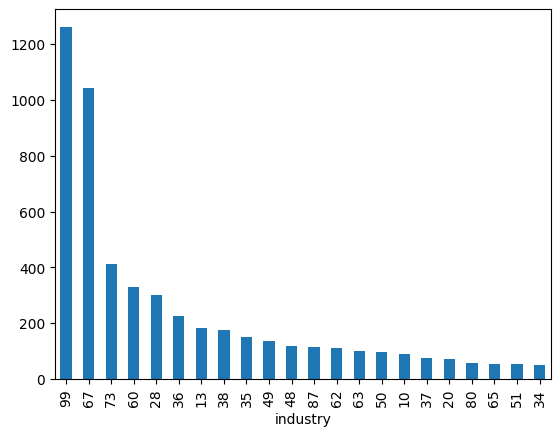

In [ ]:
ind = crsp.groupby("industry")['permco'].nunique().sort_values(ascending=False)
#                                                  ^ Sort the values descending

ind[ind>50].plot.bar() # We cannot use .query() here, because ind is a Series, not a DataFrame

## Price plot

Consider data as of 2019-05-16. Get the companies that satisfy the following conditions:
- Market cap greater or equal to USD 2.5 billion
- Not in the industry "99"
- Return greater than 0.05

How many are there?

**For the rest of the case study, we will only work with these companies.**

If you can't solve it, pick 10 companies however you like and work with them going forward.

In [ ]:
mcrsp = crsp.query('(date == "2019-05-16") & (mcap >= 2.5e9) & (ret > 0.05) & (industry != "99")')
#                                          ^ and             ^ and          ^ and
# Join all four conditions by and's

<ipython-input-20-b34b7aec0c4f>:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  mcrsp = crsp.query('(date == "2019-05-16") & (mcap >= 2.5e9) & (ret > 0.05) & (industry != "99")')


In [ ]:
print(f"There are {len(mcrsp)} companies that satisfy the filters.")

There are 13 companies that satisfy the filters.


Plot these companies' share price development over the entire year.

In [ ]:
# Extract the tickers
companies = mcrsp.loc[:,'ticker']
companies

,ticker
427016,SHOP
472379,PEN
531283,TWLO
587028,SNAP
596304,CVNA
696621,PAGS
929310,BYND
1033264,IMMU
1152334,CSCO
1270290,PENN


In [ ]:
# Filter the dataframe to the relevant companies
filtered_crsp = crsp.query("ticker in @companies")

<Axes: xlabel='date', ylabel='prc'>

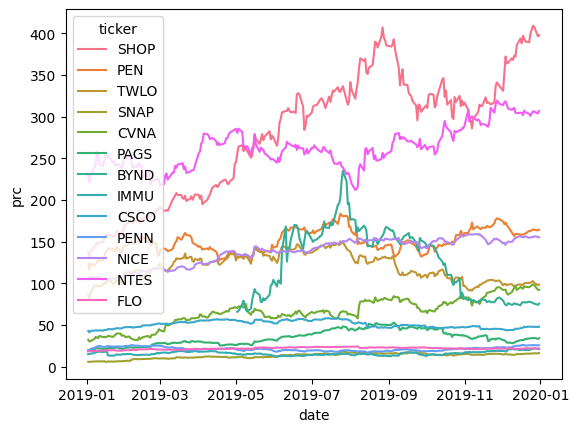

In [ ]:
sns.lineplot(
    data = filtered_crsp, # Use our filtered data set
    x = 'date',
    y = 'prc',
    hue = 'ticker', # Make sure we get separate lines for each company ticker
)

## Analyzing the data

Now `pivot` (hint!) the (filtered) data to get the `ret` as values, the `date` as index and the `ticker` in the columns.

In [ ]:
ret_crsp = filtered_crsp.pivot(values='ret',index='date',columns='ticker')

Calculate the return correlations of the companies.

In [ ]:
ret_crsp.corr()

ticker,BYND,CSCO,CVNA,FLO,IMMU,NICE,NTES,PAGS,PEN,PENN,SHOP,SNAP,TWLO
ticker,,,,,,,,,,,,,
BYND,1.000000,0.049800,0.074979,-0.059052,0.064882,0.036255,0.032718,0.118552,0.065577,0.098288,0.119422,0.143152,0.238840
CSCO,0.049800,1.000000,0.273580,0.119127,0.268072,0.366504,0.373534,0.319379,0.352558,0.381565,0.289350,0.290844,0.385083
CVNA,0.074979,0.273580,1.000000,-0.067208,0.100040,0.234808,0.377455,0.305583,0.148325,0.322322,0.349180,0.235900,0.411872
FLO,-0.059052,0.119127,-0.067208,1.000000,-0.008814,0.231748,-0.003245,0.119066,0.125730,0.054178,0.096771,0.023068,0.123079
IMMU,0.064882,0.268072,0.100040,-0.008814,1.000000,0.079985,0.112642,0.050894,0.183331,0.326259,0.068805,0.019465,0.139239
NICE,0.036255,0.366504,0.234808,0.231748,0.079985,1.000000,0.310164,0.282450,0.234178,0.268875,0.334109,0.224826,0.426178
NTES,0.032718,0.373534,0.377455,-0.003245,0.112642,0.310164,1.000000,0.250849,0.150691,0.271268,0.304190,0.156481,0.323231
PAGS,0.118552,0.319379,0.305583,0.119066,0.050894,0.282450,0.250849,1.000000,0.162545,0.285559,0.404234,0.241107,0.450641
PEN,0.065577,0.352558,0.148325,0.125730,0.183331,0.234178,0.150691,0.162545,1.000000,0.197485,0.152200,0.198086,0.316963


Since that's hard to grasp quickly, plot a heatmap. Choose a diverging colormap from the [available ones](https://seaborn.pydata.org/tutorial/color_palettes.html).

<Axes: xlabel='ticker', ylabel='ticker'>

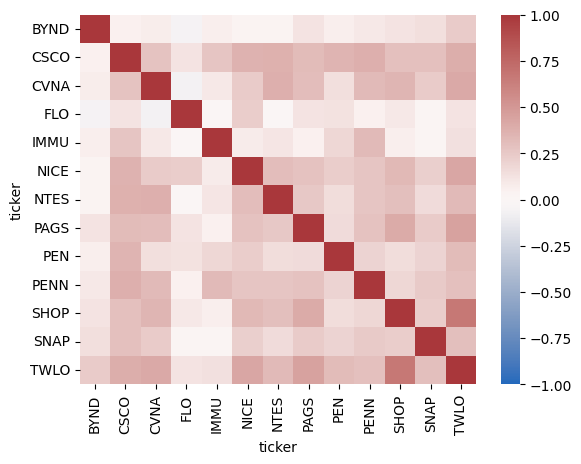

In [ ]:
sns.heatmap(
    data = ret_crsp.corr(),
    vmin = -1,
    vmax = 1,
    cmap = "vlag",
)

Which company pair has the highest correlation? Get it via code. Ignore correlations of the companies with themselves. [Difficult task!]

In [ ]:
# The simple approach
correlations = ret_crsp.corr().replace(1.0, 0.0) # We know that the values on the diagonal are exact 1.0, which don't occur anywhere else -> replace with 0, so it's no longer the highest.

# Solve it stepwise. Get row and column with highest correlation separately.
column_with_highest_correlation = correlations.abs().max().idxmax() # Get the column with the highest value
row_with_highest_correlation = correlations.loc[:,column_with_highest_correlation].idxmax() # Get the row with the highest value in the column with the highest correlation

# Print it in a nice way
print(f"The company pair with the highest correlation is {column_with_highest_correlation}-{row_with_highest_correlation}")

The company pair with the highest correlation is SHOP-TWLO


In [ ]:
# The more elegant approach
correlations = ret_crsp.corr()

pair = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool)).stack().abs().idxmax()
#                                 ^ create a matrix of 1 in the same shape as the original data
#                            ^ upper triangular                ^ with offset from diagonal of 1 -> excludes the diagonal itself -> keeps only the 1's from before that in the upper triangular
#                                                                  ^ convert 1.0 and 0.0 to True and False
#                  ^ Essentially delete all cell values where the condition is False -> deletes the lower triangular and the diagonal
#                                                                                ^ Pull the columns into the index, so that we have ticker pairs in the index now (and have a pd.Series, no pd.DataFrame anymore)
#                                                                                        ^ Take absolute values
#                                                                                              ^ Get the index (where we now have the ticker pairs) with the highest value


print(f"The company pair with the highest correlation is {'-'.join(pair)}")
#                                                             ^ puts a '-' between all elements of the tuple pairs -> from ('SHOP','TWLO') to 'SHOP-TWLO'

The company pair with the highest correlation is SHOP-TWLO


## Portfolio weighting schemes

In many scenarios, we want to build portfolios of companies. When combining them, a choice has to be made on how to weight them.

The easiest way is equal weighting. A very popular way is value weighting.

In the following, we will want to convert from returns to prices in order to plot meaningful stock price developments. Write a function that takes a return column as input and returns a column of prices as output.

The function should have a keyword argument `initial_value` that is set to `100` by default and is the amount of money invested in the first period.

In [ ]:
# Test your function with these returns
test_returns = pd.Series([0.1, -0.1, 0.2, -0.2])

In [ ]:
def returns_to_prices(returns, initial_value = 100):
  return returns.add(1).cumprod().multiply(initial_value)

In [ ]:
returns_to_prices(test_returns)

,0
0,110.00
1,99.00
2,118.80
3,95.04


### Equal weighting

Equal weighting means that all stocks in a portfolio have the same weight.

Calculate an equal weighted portfolio return and plot the portfolio value over the year.

In [ ]:
ewret = ret_crsp.mean(axis=1)
#                     ^ specify the axis keyword so that we don't take means per column, but per row (we want the returns to be averaged per time period)

<Axes: xlabel='date'>

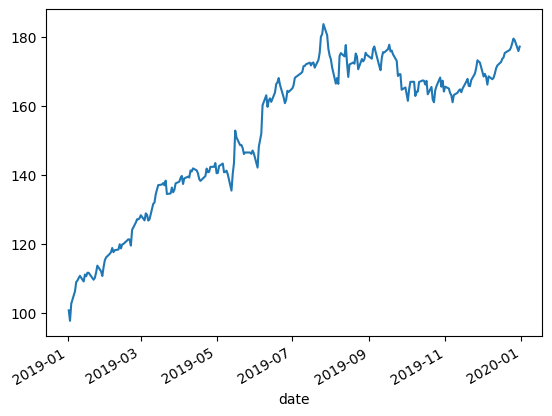

In [ ]:
returns_to_prices(ewret).plot()

### Value weighting

Value weighting means that stocks are weighted proportionally to their market capitalization. Thus, we need to calculate their percentage of the total market cap at each point in time. This does not require a loop!

Hint: We can split the problem into two parts. A returns DataFrame and a weights DataFrame, which we can then multiply with each other.



Get a market capitalization DataFrame similar to the returns data via `pivot`.

In [ ]:
wcrsp = filtered_crsp.pivot(values='mcap',index='date',columns='ticker')

Now we can divide the individual market caps by the row-wise (point in time) total market capitalization. Giving us the percentage market share of each stock at each point in time.

In [ ]:
wcrsp = wcrsp.divide(wcrsp.sum(axis=1),axis=0)
#                          ^ get the total market share at each point in time
#             ^ Divide the individual values by the sum to get the percentage

In [ ]:
wcrsp.head(2)

ticker,BYND,CSCO,CVNA,FLO,IMMU,NICE,NTES,PAGS,PEN,PENN,SHOP,SNAP,TWLO
date,,,,,,,,,,,,,
2019-01-02,NaN,0.748879,0.004860,0.015016,0.011062,0.017388,0.065230,0.012174,0.016468,0.008802,0.050912,0.022001,0.027208
2019-01-03,NaN,0.747564,0.004748,0.015847,0.011448,0.017831,0.065476,0.012285,0.016181,0.009420,0.050132,0.022531,0.026535


Plot a stacked barchart that shows the average proportion invested in each company in each month.

Check the documentation for [pd.Grouper](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html), which is used for advanced grouping. It is particularly useful for grouping based on time frequencies.

<Axes: xlabel='date'>

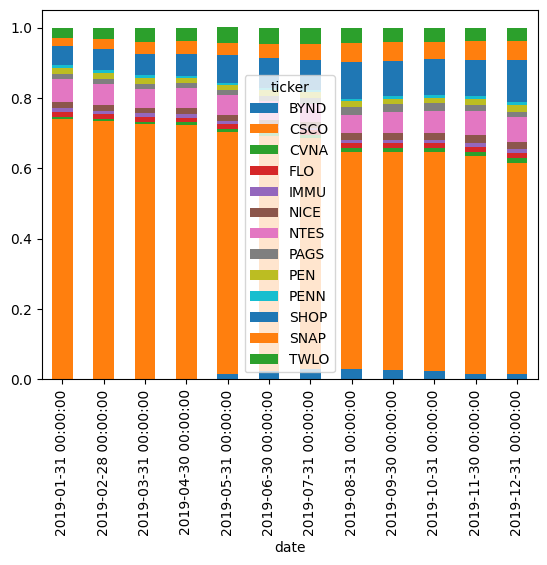

In [ ]:
wcrsp.groupby(pd.Grouper(freq='ME')).mean().plot.bar(stacked=True)
#             ^ by default groups the index. we have dates there. group them by calendar month.
#                                  ^ Take the average
#                                          ^ Plot a bar chart with the keyword argument stacked so that we stack them

Now let's value-weight the returns.

If we use `.multiply()`, we can perform an element-wise multiplication if both dataframes have the same size (which we have).
So we are multiplying the return with the weight of that return.

Then we take the sum for each row, meaning for each point in time. Now we have our portfolio return.

In [ ]:
vwret = ret_crsp.multiply(wcrsp).sum(axis=1)

Plot the performance of the value weighted portfolio over the year.

<Axes: xlabel='date'>

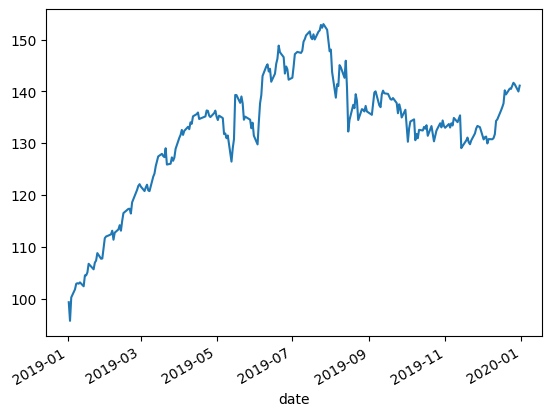

In [ ]:
# Convert the portfolio returns to prices, then plot
returns_to_prices(vwret).plot()

### Comparison

It's hard to tell the difference between the performance and the equal-weighted portfolio and the value-weighted porfolio, so let's plot both lines in one chart and label them accordingly. Hint: Use `pd.concat` for this.

In [ ]:
comparison = pd.concat([returns_to_prices(vwret),returns_to_prices(ewret)],axis=1)
#               ^ Concatenate all DataFrames in the list                   ^ along axis 1 -> along columns -> essentially add new columns

# Rename the columns to something useful.
comparison.columns = ['vw','ew']


<Axes: xlabel='date'>

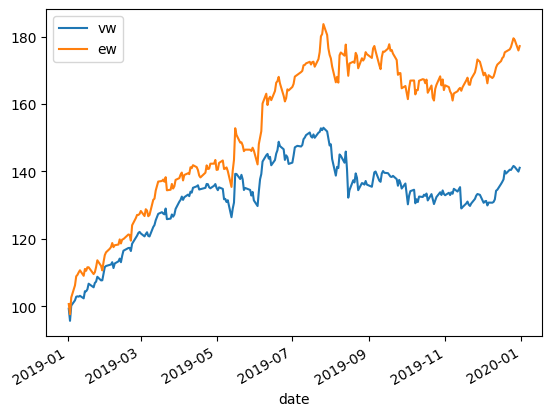

In [ ]:
comparison.plot()

Which one performs better?

The equal weighted portfolio.

## Statistical tests

Extract the values from the `vwretd` column of the data and merge them with the equal-weighted and value-weighted returns into one dataframe that has 3 columns, `['ewret','vwret','vwretd']`.
Look at WRDS to find out what the `vwretd` column means.

We now have returns on 3 different portfolios in one dataframe.

In [ ]:
vwretd = filtered_crsp[['date','vwretd']].drop_duplicates().set_index('date')
portfolio_ret_with_benchmark = pd.concat([ewret, vwret, vwretd], axis=1)
portfolio_ret_with_benchmark.columns = ['ewret','vwret','vwretd']

# VWRETD is the value-weighted market portfolio
# Details:
# VWRETD indices contain either the daily or monthly returns, including all distributions, on a value-weighted market portfolio (excluding American Depository Receipts (ADRs)).

What is the mean return for each portfolio?

In [ ]:
portfolio_ret_with_benchmark.mean()

,0
ewret,0.002378
vwret,0.001460
vwretd,0.001051


Run pairwise ttests for equality of means between all column combinations. Which portfolio combination is the most likely to have similar means (check manually)?

*Hint: Check the documentation, there is a shortcut.*

In [ ]:
portfolio_ret_with_benchmark.ptests(stars=False) # Note that this DataFrame method is added by pingouin
# vwret and vwretd are the most likely to have the same mean

,ewret,vwret,vwretd
ewret,-,0.467,0.201
vwret,0.729,-,0.678
vwretd,1.28,0.415,-


In [ ]:
# Equivalent way using pg.ttest
test_results = []
for x,y in [(0,1), (0,2), (1,2)]: # You could build these combinations with itertools
  test_results.append(
      pg.ttest(
        portfolio_ret_with_benchmark.iloc[:,x],
        portfolio_ret_with_benchmark.iloc[:,y],
        ).rename(index={'T-test':f'{x}-{y}'})
  )
test_results = pd.concat(test_results)
test_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
0-1,0.728669,502,two-sided,0.466544,"[-0.0, 0.0]",0.064915,0.128,0.112448
0-2,1.279812,502,two-sided,0.201202,"[-0.0, 0.0]",0.114015,0.219,0.248033
1-2,0.415126,502,two-sided,0.678227,"[-0.0, 0.0]",0.036982,0.108,0.069888


Check whether the return correlation between the different portfolios is statistically significant.

In [ ]:
pg.pairwise_corr(portfolio_ret_with_benchmark)
# They are all statistically significant.

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,ewret,vwret,pearson,two-sided,252,0.818792,"[0.77, 0.86]",3.416035e-62,4.733e+58,1.0
1,ewret,vwretd,pearson,two-sided,252,0.734540,"[0.67, 0.79]",5.407445e-44,4.638e+40,1.0
2,vwret,vwretd,pearson,two-sided,252,0.760018,"[0.7, 0.81]",1.077298e-48,2.066e+45,1.0
